In [1]:
from stim import __version__
print(__version__)

1.16.dev1751171094


In [2]:
import stim
import numpy as np
import matplotlib.pyplot as plt

# Encoding Cirucuit

In [224]:
def logical_plus(qc: stim.Circuit, first_qubit: int, p1_err: float, p2_err: float, meas_err: float, encoding_num: int):
    for i in [0, 1, 3]:
        qc.append("H", [first_qubit+i])
        qc.append("DEPOLARIZE1", [first_qubit+i], p1_err)
    
    cx_list = [[first_qubit, first_qubit+4], [first_qubit+1, first_qubit+2], [first_qubit+3, first_qubit+5], [first_qubit, first_qubit+6], [first_qubit+3, first_qubit+4], [first_qubit+1, first_qubit+5], [first_qubit, first_qubit+2], [first_qubit+5, first_qubit+6]]
    for cx in cx_list:
        qc.append("CX", cx)
        qc.append("DEPOLARIZE2", cx, p2_err)
        
    list = [[first_qubit+4, first_qubit+7], [first_qubit+2, first_qubit+7], [first_qubit+5, first_qubit+7]]
    for cx in list:
        qc.append("CX", cx)
        qc.append("DEPOLARIZE2", cx, p2_err)
    
    qc.append("X_ERROR", [first_qubit+7], meas_err)
    qc.append("MR", [first_qubit+7])
    qc.append("DETECTOR", [stim.target_rec(encoding_num)])
    
    for i in range(7):
        qc.append("H", [first_qubit+i])
        qc.append("DEPOLARIZE1", [first_qubit+i], p1_err)

# Measurement Circuit

In [225]:
def final_measurements(qc: stim.Circuit, meas_err: float):
    qc.append("X_ERROR", range(14), meas_err)
    qc.append("MR", range(14))
    # Stabilizers for block1
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-14), stim.target_rec(-12), stim.target_rec(-10), stim.target_rec(-8)], 0)
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9),  stim.target_rec(-8)], 1)
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-9),  stim.target_rec(-8)], 2)
    # Stabilizers for block2
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-5), stim.target_rec(-3), stim.target_rec(-1)], 3)
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)], 4)
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-6), stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-1)], 5)
    # Logical Operator for block1
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12)], 6)
    # Logical Operator for block2
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)], 7)

# Entire CZ Circuit

In [226]:
def cz_circuit(qc: stim.Circuit, p1_err: float, p2_err: float, meas_err: float, rep: int):
    logical_plus(qc, first_qubit=0, p1_err=p1_err, p2_err=p2_err, meas_err=p2_err, encoding_num=-1)
    logical_plus(qc, first_qubit=7, p1_err=p1_err, p2_err=p2_err, meas_err=p2_err, encoding_num=-2)
    
    for r in range(rep):
        for i in range(7):
            qc.append("CZ", [i, i+7])
            qc.append("DEPOLARIZE2", [i, i+7], p2_err)
            qc.append("H", [i])
            qc.append("DEPOLARIZE1", [i], p1_err)
    final_measurements(qc, meas_err)

# Decoder

In [227]:
def decoder(dets, obs):
    shots = obs.shape[0]
    error = 0
    erase = 0
    
    for i in range(shots):
        if (not dets[i][0] and not dets[i][1]):
            b1_checks = obs[i][0:3]
            b2_checks = obs[i][3:6]
            b1_op = obs[i][6]
            b2_op = obs[i][7]
            if (b1_checks[1]):
                pass
            elif (b1_checks[0] or b1_checks[2]):
                b1_op = not b1_op

            if (b2_checks[1]):
                pass
            elif (b2_checks[0] or b2_checks[2]):
                b2_op = not b2_op
        
            if (b1_op != b2_op):
                error += 1
        else:
            erase += 1
    err_rate = error/(shots - erase)
    unc = 1.96 * np.sqrt( (err_rate * (1 - err_rate) / (shots - erase) ))
    return err_rate, unc

# Simulations

H 0
DEPOLARIZE1(0.0001) 0
H 1
DEPOLARIZE1(0.0001) 1
H 3
DEPOLARIZE1(0.0001) 3
CX 0 4
DEPOLARIZE2(0.001) 0 4
CX 1 2
DEPOLARIZE2(0.001) 1 2
CX 3 5
DEPOLARIZE2(0.001) 3 5
CX 0 6
DEPOLARIZE2(0.001) 0 6
CX 3 4
DEPOLARIZE2(0.001) 3 4
CX 1 5
DEPOLARIZE2(0.001) 1 5
CX 0 2
DEPOLARIZE2(0.001) 0 2
CX 5 6
DEPOLARIZE2(0.001) 5 6
CX 4 7
DEPOLARIZE2(0.001) 4 7
CX 2 7
DEPOLARIZE2(0.001) 2 7
CX 5 7
DEPOLARIZE2(0.001) 5 7
X_ERROR(0.001) 7
MR 7
DETECTOR rec[-1]
H 0
DEPOLARIZE1(0.0001) 0
H 1
DEPOLARIZE1(0.0001) 1
H 2
DEPOLARIZE1(0.0001) 2
H 3
DEPOLARIZE1(0.0001) 3
H 4
DEPOLARIZE1(0.0001) 4
H 5
DEPOLARIZE1(0.0001) 5
H 6
DEPOLARIZE1(0.0001) 6
H 7
DEPOLARIZE1(0.0001) 7
H 8
DEPOLARIZE1(0.0001) 8
H 10
DEPOLARIZE1(0.0001) 10
CX 7 11
DEPOLARIZE2(0.001) 7 11
CX 8 9
DEPOLARIZE2(0.001) 8 9
CX 10 12
DEPOLARIZE2(0.001) 10 12
CX 7 13
DEPOLARIZE2(0.001) 7 13
CX 10 11
DEPOLARIZE2(0.001) 10 11
CX 8 12
DEPOLARIZE2(0.001) 8 12
CX 7 9
DEPOLARIZE2(0.001) 7 9
CX 12 13
DEPOLARIZE2(0.001) 12 13
CX 11 14
DEPOLARIZE2(0.001) 11 14

Text(0, 0.5, 'logical error')

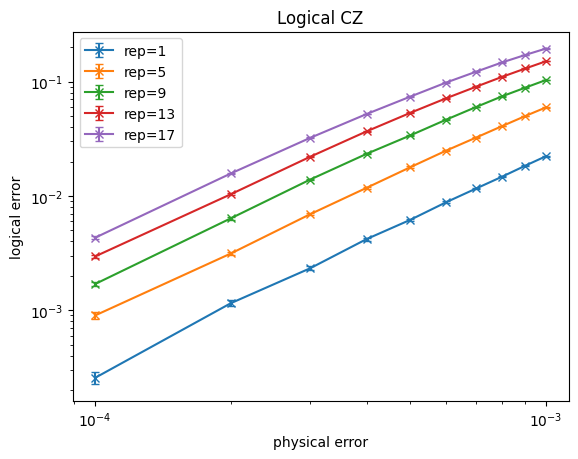

In [228]:
noise_list = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
shots = int(1e6)
all_error = []
all_unc = []

for rep in range(1, 18, 4):
    logical_err = []
    unc = []
    for p1 in noise_list:
        qc = stim.Circuit()
        cz_circuit(qc, p1_err=p1, p2_err=p1*10, meas_err=p1*10, rep=rep)
        print(qc)

        dets, obs = qc.compile_detector_sampler().sample(shots=shots,separate_observables=True)
        err_rate, u = decoder(dets, obs)
        logical_err.append(err_rate)
        unc.append(u)
    plt.errorbar(
        noise_list,
        logical_err,
        yerr=unc,
        fmt='-x',
        label=f'rep={rep}',
        capsize=3  # little horizontal caps on the error bars
    )
    all_error.append(logical_err)
    all_unc.append(unc)

plt.title('Logical CZ')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('physical error')
plt.ylabel('logical error')

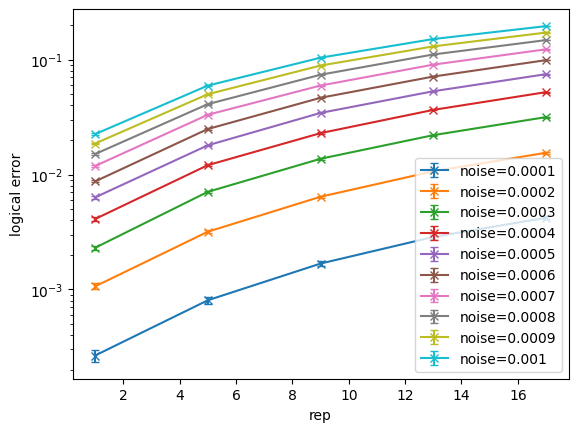

In [8]:
# all_error.shape == (num_reps, num_noises)
# uncertainties.shape == (num_reps, num_noises)
all_error = np.array(all_error)
all_unc = np.array(all_unc)
num_reps, num_noises = all_error.shape

x = range(1, 18, 4)

for k in range(num_noises):
    plt.errorbar(
        x,
        all_error[:, k],
        yerr=all_unc[:, k],
        fmt='-x',
        capsize=3,
        label=f'noise={noise_list[k]}'
    )

plt.yscale('log')
plt.legend()
plt.xlabel('rep')
plt.ylabel('logical error')
plt.show()

H 0
DEPOLARIZE1(0.0001) 0
H 1
DEPOLARIZE1(0.0001) 1
H 3
DEPOLARIZE1(0.0001) 3
CX 0 4
DEPOLARIZE2(0.001) 0 4
CX 1 2
DEPOLARIZE2(0.001) 1 2
CX 3 5
DEPOLARIZE2(0.001) 3 5
CX 0 6
DEPOLARIZE2(0.001) 0 6
CX 3 4
DEPOLARIZE2(0.001) 3 4
CX 1 5
DEPOLARIZE2(0.001) 1 5
CX 0 2
DEPOLARIZE2(0.001) 0 2
CX 5 6
DEPOLARIZE2(0.001) 5 6
CX 4 7
DEPOLARIZE2(0.001) 4 7
CX 2 7
DEPOLARIZE2(0.001) 2 7
CX 5 7
DEPOLARIZE2(0.001) 5 7
X_ERROR(0.001) 7
MR 7
DETECTOR rec[-1]
H 0
DEPOLARIZE1(0.0001) 0
H 1
DEPOLARIZE1(0.0001) 1
H 2
DEPOLARIZE1(0.0001) 2
H 3
DEPOLARIZE1(0.0001) 3
H 4
DEPOLARIZE1(0.0001) 4
H 5
DEPOLARIZE1(0.0001) 5
H 6
DEPOLARIZE1(0.0001) 6
H 7
DEPOLARIZE1(0.0001) 7
H 8
DEPOLARIZE1(0.0001) 8
H 10
DEPOLARIZE1(0.0001) 10
CX 7 11
DEPOLARIZE2(0.001) 7 11
CX 8 9
DEPOLARIZE2(0.001) 8 9
CX 10 12
DEPOLARIZE2(0.001) 10 12
CX 7 13
DEPOLARIZE2(0.001) 7 13
CX 10 11
DEPOLARIZE2(0.001) 10 11
CX 8 12
DEPOLARIZE2(0.001) 8 12
CX 7 9
DEPOLARIZE2(0.001) 7 9
CX 12 13
DEPOLARIZE2(0.001) 12 13
CX 11 14
DEPOLARIZE2(0.001) 11 14

Text(0, 0.5, 'logical error')

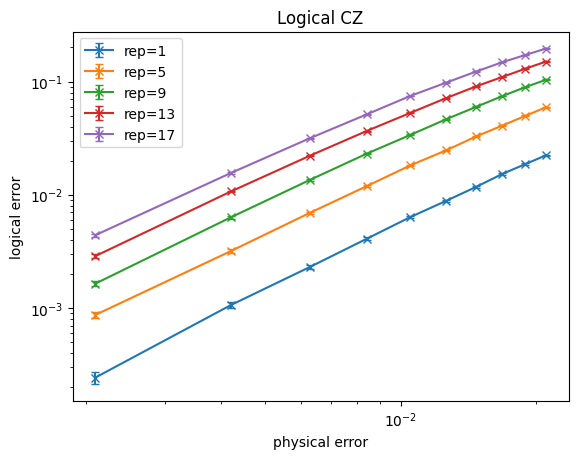

In [231]:
noise_list = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
shots = int(1e6)
all_error = []
all_unc = []

for rep in range(1, 18, 4):
    logical_err = []
    unc = []
    total_noise_list = []
    for p1 in noise_list:
        qc = stim.Circuit()
        cz_circuit(qc, p1_err=p1, p2_err=p1*10, meas_err=p1*10, rep=rep)
        print(qc)

        dets, obs = qc.compile_detector_sampler().sample(shots=shots,separate_observables=True)
        err_rate, u = decoder(dets, obs)
        logical_err.append(err_rate)
        unc.append(u)
        total_noise_list.append(21*p1)
    plt.errorbar(
        total_noise_list,
        logical_err,
        yerr=unc,
        fmt='-x',
        label=f'rep={rep}',
        capsize=3  # little horizontal caps on the error bars
    )
    all_error.append(logical_err)
    all_unc.append(unc)

plt.title('Logical CZ')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('physical error')
plt.ylabel('logical error')

# Biased noise

H 0
DEPOLARIZE1(0.0002) 0
H 1
DEPOLARIZE1(0.0002) 1
H 3
DEPOLARIZE1(0.0002) 3
CX 0 4
DEPOLARIZE2(0.0002) 0 4
CX 1 2
DEPOLARIZE2(0.0002) 1 2
CX 3 5
DEPOLARIZE2(0.0002) 3 5
CX 0 6
DEPOLARIZE2(0.0002) 0 6
CX 3 4
DEPOLARIZE2(0.0002) 3 4
CX 1 5
DEPOLARIZE2(0.0002) 1 5
CX 0 2
DEPOLARIZE2(0.0002) 0 2
CX 5 6
DEPOLARIZE2(0.0002) 5 6
CX 4 7
DEPOLARIZE2(0.0002) 4 7
CX 2 7
DEPOLARIZE2(0.0002) 2 7
CX 5 7
DEPOLARIZE2(0.0002) 5 7
X_ERROR(0.0002) 7
MR 7
DETECTOR rec[-1]
H 0
DEPOLARIZE1(0.0002) 0
H 1
DEPOLARIZE1(0.0002) 1
H 2
DEPOLARIZE1(0.0002) 2
H 3
DEPOLARIZE1(0.0002) 3
H 4
DEPOLARIZE1(0.0002) 4
H 5
DEPOLARIZE1(0.0002) 5
H 6
DEPOLARIZE1(0.0002) 6
H 7
DEPOLARIZE1(0.0002) 7
H 8
DEPOLARIZE1(0.0002) 8
H 10
DEPOLARIZE1(0.0002) 10
CX 7 11
DEPOLARIZE2(0.0002) 7 11
CX 8 9
DEPOLARIZE2(0.0002) 8 9
CX 10 12
DEPOLARIZE2(0.0002) 10 12
CX 7 13
DEPOLARIZE2(0.0002) 7 13
CX 10 11
DEPOLARIZE2(0.0002) 10 11
CX 8 12
DEPOLARIZE2(0.0002) 8 12
CX 7 9
DEPOLARIZE2(0.0002) 7 9
CX 12 13
DEPOLARIZE2(0.0002) 12 13
CX 11 14
DEPO

Text(0, 0.5, 'logical error')

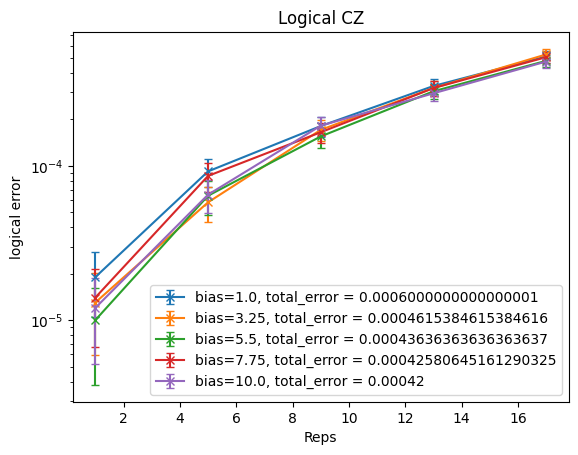

In [247]:
noise_list = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
bias_list = np.linspace(1,10,5)
shots = int(1e6)
all_error = []
all_unc = []
p1 = 0.0002

for bias in bias_list:
    logical_err = []
    unc = []
    total_noise_list = []
    for rep in range(1, 18, 4):
        qc = stim.Circuit()
        cz_circuit(qc, p1_err=p1, p2_err=p1, meas_err=p1/bias, rep=rep)
        print(qc)

        dets, obs = qc.compile_detector_sampler().sample(shots=shots,separate_observables=True)
        err_rate, u = decoder(dets, obs)
        logical_err.append(err_rate)
        unc.append(u)
        total_noise_list.append(p1+p1+(p1/bias))
    plt.errorbar(
        range(1, 18, 4),
        logical_err,
        yerr=unc,
        fmt='-x',
        label=f'bias={bias}, total_error = {p1+p1+(p1/bias)}',
        capsize=3  # little horizontal caps on the error bars
    )
    all_error.append(logical_err)
    all_unc.append(unc)

plt.title('Logical CZ')
plt.yscale('log')
plt.legend()
plt.xlabel('Reps')
plt.ylabel('logical error')

[np.float64(0.00021), np.float64(0.00032), np.float64(0.00043000000000000004), np.float64(0.00054), np.float64(0.0006500000000000001), np.float64(0.0007600000000000002), np.float64(0.0008700000000000001), np.float64(0.00098), np.float64(0.00109), np.float64(0.0012000000000000001)]
[0.5018811286772064, 0.4996194443888077, 0.49958914542247873, 0.5017192810097142, 0.49992977387186743, 0.49709915082408207, 0.5010753336549284, 0.49922098808865656, 0.5001861447904613, 0.4985048479173589]
[np.float64(0.001180916782899733), np.float64(0.001799492240609117), np.float64(0.002418067698318501), np.float64(0.003036643156027885), np.float64(0.003655218613737269), np.float64(0.004273794071446653), np.float64(0.004892369529156037), np.float64(0.005510944986865421), np.float64(0.006129520444574805), np.float64(0.006748095902284189)]
[0.5029559072979294, 0.5028711893776068, 0.5010979003288641, 0.49853777416734363, 0.4955373517544932, 0.5017599148692342, 0.49636191729014223, 0.4969904973924515, 0.5012157

Text(0, 0.5, 'logical error')

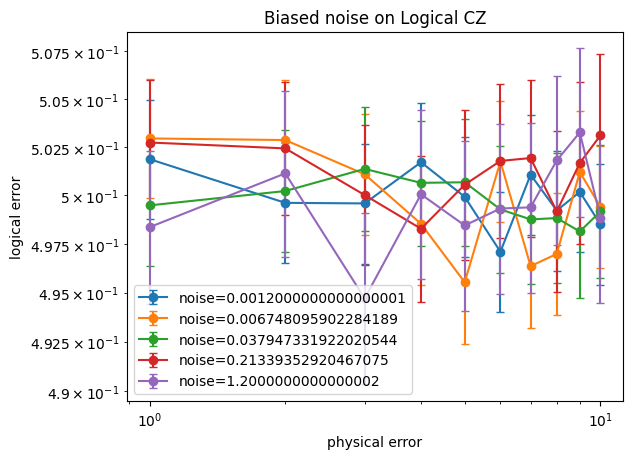

In [ ]:
noise_list = np.logspace(-5,-2,5)
shots = int(1e5)
all_error = []
all_unc = []
bias_list = np.linspace(1, 10, 10)
rep = 2

for p1 in noise_list:
    logical_err = []
    unc = []
    total_noise_list = []
    for bias in bias_list:
        qc = stim.Circuit()
        
        cz_circuit(qc, p1_err=p1*10, p2_err=p1*bias*10, meas_err=p1*10, rep=rep)

        dets, obs = qc.compile_detector_sampler().sample(shots=shots,separate_observables=True)
        err_rate, u = decoder(dets, obs)
        logical_err.append(err_rate)
        unc.append(u)
        total_noise_list.append(p1 * bias + p1*bias*10 + p1*10)
    print(total_noise_list)
    print(logical_err)
    plt.errorbar(
        bias_list,
        logical_err,
        yerr=unc,
        fmt='-o',
        label=f'noise={p1 * bias + p1*bias*10 + p1*10}',
        capsize=3  # little horizontal caps on the error bars
    )
    all_error.append(logical_err)
    all_unc.append(unc)

plt.title('Biased noise on Logical CZ')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('physical error')
plt.ylabel('logical error')

# Attempting to use sinter (so far unsuccessful)

In [84]:
import sinter
from typing import List 

In [145]:
def sinter_logical_plus(qc: stim.Circuit, first_qubit: int, p1_err: float, p2_err: float, meas_err: float, encoding_num: int):
    for i in [0, 1, 3]:
        qc.append("H", [first_qubit+i])
        qc.append("DEPOLARIZE1", [first_qubit+i], p1_err)
    
    cx_list = [[first_qubit, first_qubit+4], [first_qubit+1, first_qubit+2], [first_qubit+3, first_qubit+5], [first_qubit, first_qubit+6], [first_qubit+3, first_qubit+4], [first_qubit+1, first_qubit+5], [first_qubit, first_qubit+2], [first_qubit+5, first_qubit+6]]
    for cx in cx_list:
        qc.append("CX", cx)
        qc.append("DEPOLARIZE2", cx, p2_err)
        
    list = [[first_qubit+4, first_qubit+7], [first_qubit+2, first_qubit+7], [first_qubit+5, first_qubit+7]]
    for cx in list:
        qc.append("CX", cx)
        qc.append("DEPOLARIZE2", cx, p2_err)
    
    qc.append("X_ERROR", [first_qubit+7], meas_err)
    qc.append("MR", [first_qubit+7])
    qc.append("DETECTOR", [stim.target_rec(encoding_num)], 8)
    
    for i in range(7):
        qc.append("H", [first_qubit+i])
        qc.append("DEPOLARIZE1", [first_qubit+i], p1_err)

In [216]:
def sinter_final_measurements(qc: stim.Circuit, meas_err: float):
    qc.append("X_ERROR", range(14), meas_err)
    qc.append("M", range(14))

    qc.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-12), stim.target_rec(-10), stim.target_rec(-8)], 0)
    qc.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9),  stim.target_rec(-8)], 1)
    qc.append("DETECTOR", [stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-9),  stim.target_rec(-8)], 2)

    
    # Stabilizers for block
    qc.append("DETECTOR", [stim.target_rec(-7), stim.target_rec(-5), stim.target_rec(-3), stim.target_rec(-1)], 3)
    qc.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)], 4)
    qc.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-1)], 5)

    # qc.append("DETECTOR", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12)], 6)
    # # # Logical Operator for block2
    # qc.append("DETECTOR", [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)], 7)


    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-14), stim.target_rec(-12), stim.target_rec(-10), stim.target_rec(-8)], 0)
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9),  stim.target_rec(-8)], 1)
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-13), stim.target_rec(-12), stim.target_rec(-9),  stim.target_rec(-8)], 2)
    # # # Stabilizers for block2
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-5), stim.target_rec(-3), stim.target_rec(-1)], 3)
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)], 4)
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-6), stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-1)], 5)
    # # Logical Operator for block1
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-14), stim.target_rec(-13), stim.target_rec(-12)], 6)
    # # # Logical Operator for block2
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)], 7)

    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-16)], 8)
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-15)], 8)
    # qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-14)], 7)
    

In [217]:
def sinter_cz_circuit(qc: stim.Circuit, p1_err: float, p2_err: float, meas_err: float, rep: int):
    sinter_logical_plus(qc, first_qubit=0, p1_err=p1_err, p2_err=p2_err, meas_err=p2_err, encoding_num=-1)
    sinter_logical_plus(qc, first_qubit=7, p1_err=p1_err, p2_err=p2_err, meas_err=p2_err, encoding_num=-2)
    # print("first circ\n\n", qc)
    for r in range(rep):
        for i in range(7):
            qc.append("CZ", [i, i+7])
            qc.append("DEPOLARIZE2", [i, i+7], p2_err)
            qc.append("H", [i])
            qc.append("DEPOLARIZE1", [i], p1_err)
    # print("second circ\n\n",qc)
    sinter_final_measurements(qc, meas_err)
    # print("third circ\n\n",qc)
    return qc

In [220]:
noise_list = np.logspace(-6,-1,8)
shots = int(1e5)
all_error = []
all_unc = []
bias_list = np.linspace(1, 100, 4)
rep = 2





def generate_example_tasks():
    for p1 in noise_list:
        for b in bias_list:
            qc = stim.Circuit()
            yield sinter.Task(
                circuit=sinter_cz_circuit(qc=qc, 
                                          p1_err=p1, 
                                          p2_err=p1, 
                                          meas_err=p1/b, 
                                          rep = 2),
                json_metadata={
                    'p': p1*((2*b+1)/b),
                    'bias': b,
                },
            )
            





collected_stats = list()
t = 0
for task in generate_example_tasks():
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        save_resume_filepath = "sinter_cz_bias_2.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1






Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        5 pymatching   ?       8000       10000 p=3e-06,bias=1.0
0 tasks left:

Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata                    
        5 pymatching   ?       8000       10000 p=2.029411764705882e-06,bias=34.0
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata                    
        5 pymatching   ?          0       10000 p=2.029411764705882e-06,bias=34.0
Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata                    
        5 pymatching   ?       8000       10000 p=2.014925373134328e-06,bias=67.0
0 tasks left:

Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata        
        5 pymatching   ?       8000       10000 p=2.01e-06,bias=100.0
0 tasks left:

Starting 5 workers...
1 tasks left:

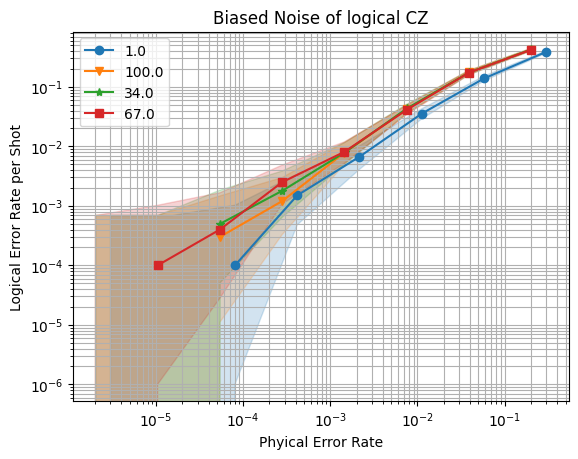

In [222]:
collected_stats = sinter.stats_from_csv_files("sinter_cz_bias_2.csv")

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['bias'],
)
# plt.xlim((1e-3,9e-1))
# plt.ylim((1e-5,9e-1))
ax.loglog()
ax.set_title("Biased Noise of logical CZ")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()

In [212]:
noise_list = np.logspace(-6,-3,8)
shots = int(1e5)
all_error = []
all_unc = []
rep_list = range(2,20,2)
rep = 2





def generate_example_tasks():
    for p1 in noise_list:
        for r in rep_list:
            qc = stim.Circuit()
            yield sinter.Task(
                circuit=sinter_cz_circuit(qc=qc, 
                                          p1_err=p1, 
                                          p2_err=p1*10, 
                                          meas_err=p1*10, 
                                          rep = r),
                json_metadata={
                    'p': (21*p1),
                    'rep': r,
                },
            )
            





collected_stats = list()
t = 0
for task in generate_example_tasks():
    task = [task]
    #print(circ)
    collected_stat: List[sinter.TaskStats] = sinter.collect(
        num_workers=5,
        tasks=task,
        decoders=['pymatching'],
        max_shots=int(10**(4)),
        max_errors=int(10**(4)),
        # count_detection_events=True,
        save_resume_filepath = "sinter_cz_rep.csv",
        print_progress = True
        )
    collected_stats = collected_stats + collected_stat
    t+=1






Starting 5 workers...


1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata  
        5 pymatching   ?       8000       10000 p=2.1e-05,rep=2
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata  
        5 pymatching   ?         18        9999 p=2.1e-05,rep=2
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata  
        5 pymatching   ?          0        9999 p=2.1e-05,rep=2
Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata  
        5 pymatching   ?       8000       10000 p=2.1e-05,rep=4
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata  
        5 pymatching   ?          0       10000 p=2.1e-05,rep=4
Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_metadata  
        5 pymatching   ?       8000       10000 p=2.1e-05,rep=6
0 tasks left:

Starting 5 workers...
1 tasks left:
  workers    decoder eta shots_left errors_left json_

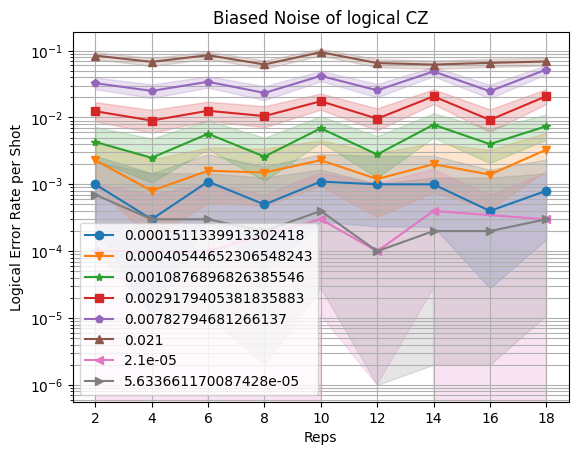

In [215]:
collected_stats = sinter.stats_from_csv_files("sinter_cz_rep.csv")

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['rep'],
    group_func=lambda stats: stats.json_metadata['p'],
)
# plt.xlim((1e-3,9e-1))
# plt.ylim((1e-5,9e-1))
ax.set_yscale("log")
ax.set_title("Biased Noise of logical CZ")
ax.set_xlabel("Reps")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()